In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

from sklearn.model_selection import train_test_split
from sklearn.utils import resample

import joblib

In [16]:
from IPython.display import display, HTML, Markdown
display(Markdown("# LOAD DATASET"))

# LOAD DATASET

In [17]:
dataset_path = r"D:\Tensoflow\tokopedia_product_reviews_2025.csv"
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"File {dataset_path} tidak ditemukan!")

df = pd.read_csv(dataset_path)
df = df[['review_text', 'rating']]

# Buat label sentimen biner
df = df[df['rating'] != 3]  # buang netral
df['sentiment'] = df['rating'].apply(lambda x: 1 if x >= 4 else 0)

print("Distribusi label asli:")
print(df['sentiment'].value_counts())

Distribusi label asli:
sentiment
1    63943
0      798
Name: count, dtype: int64


In [18]:
display(Markdown("# PRE PROCESSING"))

# PRE PROCESSING

In [19]:
def preprocess_text(text):
    text = str(text).lower()
    text = text.replace('\n', ' ').strip()
    text = ''.join([c for c in text if c.isalnum() or c == ' '])
    return text

df['review_text'] = df['review_text'].apply(preprocess_text)

In [20]:
display(Markdown("# SPLIT DATASET"))

# SPLIT DATASET

In [21]:
X = df['review_text'].values
y = df['sentiment'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("\nDistribusi TRAIN sebelum oversampling:")
print(pd.Series(y_train).value_counts())

print("\nDistribusi TEST (data asli):")
print(pd.Series(y_test).value_counts())


Distribusi TRAIN sebelum oversampling:
1    51154
0      638
Name: count, dtype: int64

Distribusi TEST (data asli):
1    12789
0      160
Name: count, dtype: int64


In [22]:
display(Markdown("# OVERSAMPLING"))

# OVERSAMPLING

In [23]:
train_df = pd.DataFrame({
    'review_text': X_train,
    'sentiment': y_train
})

df_major = train_df[train_df['sentiment'] == 1]
df_minor = train_df[train_df['sentiment'] == 0]

df_minor_upsampled = resample(
    df_minor,
    replace=True,
    n_samples=len(df_major),
    random_state=42
)

train_balanced = pd.concat([df_major, df_minor_upsampled])
train_balanced = train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

X_train_bal = train_balanced['review_text'].values
y_train_bal = train_balanced['sentiment'].values

print("\nDistribusi TRAIN setelah oversampling:")
print(pd.Series(y_train_bal).value_counts())


Distribusi TRAIN setelah oversampling:
1    51154
0    51154
Name: count, dtype: int64


In [24]:
display(Markdown("# TOKENIZATION + PADDING"))

# TOKENIZATION + PADDING

In [25]:
max_words = 5000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_bal)  # FIT HANYA TRAIN

X_train_seq = tokenizer.texts_to_sequences(X_train_bal)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# Simpan tokenizer
os.makedirs("models/saved_model", exist_ok=True)
joblib.dump(tokenizer, "models/saved_model/tokenizer.pkl")

['models/saved_model/tokenizer.pkl']

In [26]:
display(Markdown("# LSTM"))

# LSTM

In [27]:
embedding_dim = 64

model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    LSTM(64),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

c:\Users\rianv\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:100: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [28]:
display(Markdown("# TRAIN"))

# TRAIN

In [29]:
history = model.fit(
    X_train_pad,
    y_train_bal,
    epochs=5,
    batch_size=64,
    validation_split=0.1
)

Epoch 1/5
1439/1439 ━━━━━━━━━━━━━━━━━━━━ 99s 66ms/step - accuracy: 0.5081 - loss: 0.6936 - val_accuracy: 0.5213 - val_loss: 0.6861
Epoch 2/5
1439/1439 ━━━━━━━━━━━━━━━━━━━━ 94s 65ms/step - accuracy: 0.5076 - loss: 0.6954 - val_accuracy: 0.5202 - val_loss: 0.6885
Epoch 3/5
1439/1439 ━━━━━━━━━━━━━━━━━━━━ 95s 66ms/step - accuracy: 0.5066 - loss: 0.6879 - val_accuracy: 0.5202 - val_loss: 0.6862
Epoch 4/5
1439/1439 ━━━━━━━━━━━━━━━━━━━━ 96s 67ms/step - accuracy: 0.8429 - loss: 0.2634 - val_accuracy: 0.9938 - val_loss: 0.0220
Epoch 5/5
1439/1439 ━━━━━━━━━━━━━━━━━━━━ 102s 71ms/step - accuracy: 0.9940 - loss: 0.0226 - val_accuracy: 0.9971 - val_loss: 0.0104


In [30]:
display(Markdown("# EVALUATE"))

# EVALUATE

405/405 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9868 - loss: 0.1049

Test Accuracy: 98.68%


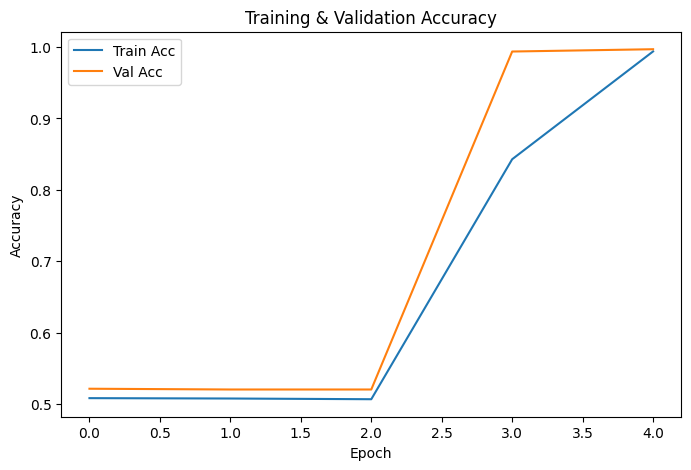

In [31]:
loss, acc = model.evaluate(X_test_pad, y_test)
print(f"\nTest Accuracy: {acc * 100:.2f}%")

plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.show()

In [32]:
display(Markdown("# SAVE"))

# SAVE

In [33]:
model.save("models/saved_model/tokopedia_sentiment_model.keras")
print("\nModel berhasil disimpan sebagai .keras")


Model berhasil disimpan sebagai .keras
